# Facial Keypoint Detection
  
This project is about defining and training a convolutional neural network to perform facial keypoint detection and using computer vision techniques to transform images of faces.  The first step in any challenge like this will be to load and visualize the data you'll be working with. 

Let's take a look at some examples of images and corresponding facial keypoints.

<img src='images/key_pts_example.png' width=50% height=50%/>

Facial keypoints (also called facial landmarks) are the small magenta dots shown on each of the faces in the image above. In each training and test image, there is a single face and **68 keypoints, with coordinates (x, y), for that face**.  These keypoints mark important areas of the face: the eyes, corners of the mouth, the nose, etc. These keypoints are relevant for a variety of tasks, such as face filters, emotion recognition, pose recognition, and so on. Here they are, numbered, and you can see that specific ranges of points match different portions of the face.

<img src='images/landmarks_numbered.jpg' width=30% height=30%/>

---

## Load and Visualize Data

The first step in working with any dataset is to become familiar with our data. This set of image data has been extracted from the [YouTube Faces Dataset](https://www.cs.tau.ac.il/~wolf/ytfaces/), which includes videos of people in YouTube videos. These videos have been fed through some processing steps and turned into sets of image frames containing one face and the associated keypoints.

#### Training and Testing Data

This facial keypoints dataset consists of 5770 color images. All of these images are separated into either a training or a test set of data.

* 3462 of these images are training images, for us to use as we create a model to predict keypoints.
* 2308 are test images, which will be used to test the accuracy of our model.

The information about the images and keypoints in this dataset are summarized in CSV files, which we can read in using `pandas`. Let's read the training CSV and get the annotations in an (N, 2) array where N is the number of keypoints and 2 is the dimension of the keypoint coordinates (x, y).

---

In [1]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torch.utils.data import Dataset

import cv2

In [2]:
key_pts_frame = pd.read_csv('data/training_frames_keypoints.csv') #reads the csv file into a pandas dataframe

n = 0
image_name = key_pts_frame.iloc[n,0] #string #name of image with extension
key_pts = key_pts_frame.iloc[n,1:].values #.values makes it into a numpy array
key_pts = key_pts.astype('float').reshape(-1,2) #change the data type to float and reshape it into a 68x2 arra

print(f'Image Name: {image_name}')

print(f'\nKey Points Shape: {key_pts.shape}')

print(f"\n first 4 key points: \n{key_pts[:4]}")

print(f"\nNumber of Images: {key_pts_frame.shape[0]}")

Image Name: Luis_Fonsi_21.jpg

Key Points Shape: (68, 2)

 first 4 key points: 
[[ 45.  98.]
 [ 47. 106.]
 [ 49. 110.]
 [ 53. 119.]]

Number of Images: 3462


## Look at some images

Below, is a function `show_keypoints` that takes in an image and keypoints and displays them.  As you look at this data, **note that these images are not all of the same size**, and neither are the faces! To eventually train a neural network on these images, we'll need to standardize their shape.

In [3]:
def show_keypoints(image, keypoints): #takes in a RGB Image and its keypoints and plot it on the same image
    plt.imshow(image)
    plt.scatter(keypoints[:,0], keypoints[:,1], s = 20, marker='.', c = 'm') 

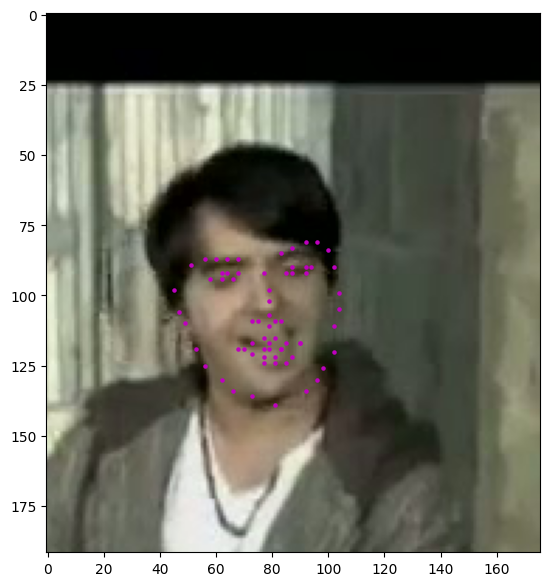

In [4]:
plt.figure(figsize=(7,7))
show_keypoints(mpimg.imread(os.path.join('data/training/', image_name)), key_pts)
plt.show()

## Dataset class and Transformations

To prepare our data for training, we'll be using PyTorch's Dataset class. Much of this this code is a modified version of what can be found in the [PyTorch data loading tutorial](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

#### Dataset class

``torch.utils.data.Dataset`` is an abstract class representing a
dataset. This class will allow us to load batches of image/keypoint data, and uniformly apply transformations to our data, such as rescaling and normalizing images for training a neural network.


The custom dataset should inherit ``Dataset`` and override the following
methods:

-  ``__len__`` so that ``len(dataset)`` returns the size of the dataset.
-  ``__getitem__`` to support the indexing such that ``dataset[i]`` can
   be used to get the i-th sample of image/keypoint data.

Let's create a dataset class for our face keypoints dataset. We will
read the CSV file in ``__init__`` but leave the reading of images to
``__getitem__``. This is memory efficient because all the images are not
stored in the memory at once but read as required.

A sample of our dataset will be a dictionary
``{'image': image, 'keypoints': key_pts}``. Our dataset will take an
optional argument ``transform`` so that any required processing can be
applied on the sample. 

In [5]:
class FacialKeypointsDataset(Dataset):
    """
    A custom dataset class for loading images and their corresponding facial keypoints.
    
    This class reads image file paths and keypoints from a CSV file and provides 
    functionality to apply optional transformations on the samples.
    
    Args:
        csv_file_address (str): Path to the CSV file containing image file names and keypoints.
        root_dir (str): Directory where the images are stored.
        transform (callable, optional): Optional transform to be applied on a sample.
    """

    def __init__(self, csv_file_address: str, root_dir: str, transform=None):
        """
        Initialize the FacialKeypointsDataset with the given parameters.
        
        Args:
            csv_file_address (str): Path to the CSV file containing image file names and keypoints.
            root_dir (str): Directory where the images are stored.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.key_pts_frame = pd.read_csv(csv_file_address)  # Read the CSV file into a DataFrame
        self.root_dir = root_dir  # Store the root directory path
        self.transform = transform  # Store the transform function (if any)

    def __len__(self):
        """
        Return the total number of samples in the dataset.
        
        Returns:
            int: The number of samples in the dataset.
        """
        return len(self.key_pts_frame)  # The length is the number of rows in the DataFrame
    
    def __getitem__(self, idx):
        """
        Retrieve the sample (image and keypoints) at the given index.
        
        Args:
            idx (int): Index of the sample to retrieve.
        
        Returns:
            dict: A dictionary containing:
                - 'image': The loaded image as a NumPy array.
                - 'keypoints': The corresponding facial keypoints as a NumPy array.
        """
        # Construct the full image file path
        image_address = os.path.join(self.root_dir, self.key_pts_frame.iloc[idx, 0])
        
        # Read the image from the file
        image = mpimg.imread(image_address)

        # Check if the image has an alpha channel (RGBA), and if so, remove it
        if image.shape[2] == 4:
            image = image[:, :, 0:3]  # Keep only the RGB channels
        
        # Extract the keypoints from the DataFrame
        key_pts = self.key_pts_frame.iloc[idx, 1:].values
        key_pts = key_pts.astype('float').reshape(-1, 2)  # Convert keypoints to a float NumPy array and reshape

        # Create a sample dictionary with the image and keypoints
        sample = {'image': image, 'keypoints': key_pts}

        # Apply the transform to the sample if one is provided
        if self.transform:
            sample = self.transform(sample)

        return sample  # Return the sample with the image and keypoints


In [6]:
# Construct the dataset
face_dataset = FacialKeypointsDataset(csv_file_address='data/training_frames_keypoints.csv', root_dir='data/training/')

# print some stats about the dataset
print('Length of dataset: ', len(face_dataset))

Length of dataset:  3462


0 (153, 168, 3) (68, 2)


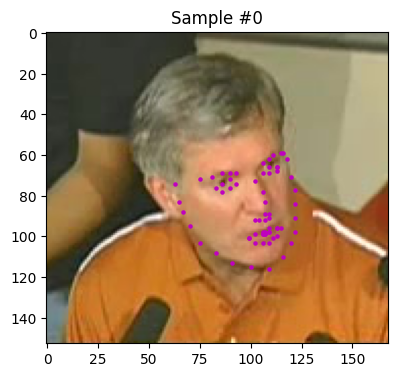

1 (232, 157, 3) (68, 2)


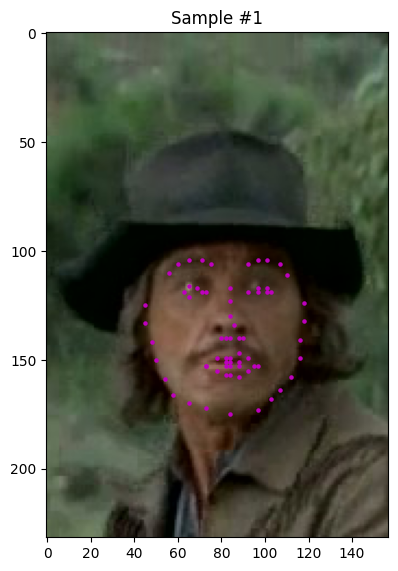

2 (235, 238, 3) (68, 2)


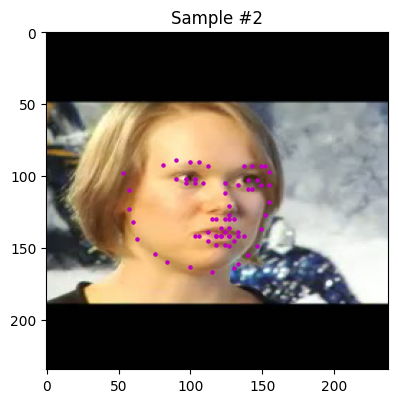

In [7]:
for i in range(3):
    fig = plt.figure(figsize=(15,10))

    rand_i = np.random.randint(0,len(face_dataset))

    sample = face_dataset[rand_i]
    print(i, sample['image'].shape, sample['keypoints'].shape)
    ax = plt.subplot(1, 3, i + 1)
    ax.set_title(f"Sample #{i}")

    show_keypoints(sample['image'], sample['keypoints'])

    plt.show()

## Transforms

Now, the images above are not of the same size, and neural networks often expect images that are standardized; a fixed size, with a normalized range for color ranges and coordinates, and (for PyTorch) converted from numpy lists and arrays to Tensors.

Therefore, we will need to write some pre-processing code.
Let's create four transforms:

-  ``Normalize``: to convert a color image to grayscale values with a range of [0,1] and normalize the keypoints to be in a range of about [-1, 1]
-  ``Rescale``: to rescale an image to a desired size.
-  ``RandomCrop``: to crop an image randomly.
-  ``ToTensor``: to convert numpy images to torch images.

We will write them as callable classes instead of simple functions so
that parameters of the transform need not be passed every time it's
called. For this, we just need to implement ``__call__`` method and 
(if we require parameters to be passed in), the ``__init__`` method. 
We can then use a transform like this:

    tx = Transform(params)
    transformed_sample = tx(sample)

In [8]:
import torch  # Importing the torch library for tensor computations
from torchvision import transforms  # Importing transforms from the torchvision library for image preprocessing

# Define a custom normalization class
class Normalize(object):
    """
    Custom normalization class for preprocessing images and their corresponding keypoints.
    """

    # The call method makes the class instance callable like a function
    def __call__(self, sample):
        """
        Apply normalization to a sample containing an image and its keypoints.

        Args:
            sample (dict): A dictionary containing:
                - 'image': The input image as a NumPy array.
                - 'keypoints': The keypoints associated with the image as a NumPy array.

        Returns:
            dict: A dictionary with normalized 'image' and 'keypoints'.
        """

        # Extract image and keypoints from the sample dictionary
        image, key_pts = sample['image'], sample['keypoints']
        
        # Make copies of the image and keypoints to avoid altering the original data
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)

        # Convert the image to grayscale using OpenCV's color conversion function
        image_copy = cv2.cvtColor(image_copy, cv2.COLOR_RGB2GRAY)
        
        # Normalize the image to a range between 0 and 1 by dividing by 255 (since image pixel values are typically in [0, 255])
        image_copy = image_copy / 255.0

        # Normalize keypoints to a range roughly between -2 and 2
        # Assuming keypoints are centered around 100 and have a rough spread of 50
        key_pts_copy = (key_pts_copy - 100) / 50.0

        # Return the normalized image and keypoints in a dictionary
        return {'image': image_copy, 'keypoints': key_pts_copy}
    
class Rescale(object):
    """
    A class to rescale the image in a sample to a given size.
    
    Args:
        output_size (tuple or int): Desired output size for rescaling the image.
            If tuple, the image will be resized to match the dimensions specified by output_size.
            If int, the smaller dimension of the image will be resized to output_size, 
            and the larger dimension will be scaled to maintain the aspect ratio.
    """
    
    def __init__(self, output_size):
        """
        Initialize the Rescale class with the specified output size.
        
        Args:
            output_size (tuple or int): Desired output size.
                - If a tuple (width, height), the image will be resized to these dimensions.
                - If an integer, the smaller edge of the image will be resized to this size, 
                  and the other edge will be scaled to maintain the aspect ratio.
        """
        # Check that output_size is either an int or a tuple
        assert isinstance(output_size, (int, tuple)), "Output size must be an integer or a tuple"
        self.output_size = output_size  # Store the provided output size

    def __call__(self, sample):
        """
        Apply the rescaling to a sample containing an image and its keypoints.
        
        Args:
            sample (dict): A dictionary containing:
                - 'image': The input image as a NumPy array.
                - 'keypoints': The keypoints associated with the image as a NumPy array.
        
        Returns:
            dict: A dictionary containing:
                - 'image': The resized image as a NumPy array.
                - 'keypoints': The adjusted keypoints scaled to the resized image.
        """
        
        # Extract the image and keypoints from the sample dictionary
        image, key_pts = sample['image'], sample['keypoints']

        # Get the height and width of the original image
        h, w = image.shape[:2]
        
        # Determine the new dimensions for the image
        if isinstance(self.output_size, int):
            # If output_size is an integer, calculate the new dimensions while maintaining the aspect ratio
            if h > w:
                # If the height is greater than the width, set the new width to output_size and scale the height
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                # If the width is greater than or equal to the height, set the new height to output_size and scale the width
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            # If output_size is a tuple, use it directly as the new dimensions
            new_h, new_w = self.output_size

        # Convert the new dimensions to integers
        new_h, new_w = int(new_h), int(new_w)
        
        # Resize the image to the new dimensions using OpenCV's resize function
        img = cv2.resize(image, (new_w, new_h))
        
        # Scale the keypoints to match the resized image
        # The keypoints are adjusted by multiplying with the ratios of the new dimensions to the original dimensions
        key_pts = key_pts * [new_w / w, new_h / h]

        # Return the resized image and adjusted keypoints in a dictionary
        return {'image': img, 'keypoints': key_pts}
    
class RandomCrop(object):
    """
    A class to randomly crop the image in a sample to a given size.
    
    Args:
        output_size (tuple or int): Desired output size for cropping the image.
            If int, a square crop of size (output_size, output_size) will be made.
            If tuple, the crop will have the dimensions specified by (height, width).
    """
    
    def __init__(self, output_size):
        """
        Initialize the RandomCrop class with the specified output size.
        
        Args:
            output_size (tuple or int): Desired output size.
                - If a tuple (height, width), the crop will match these dimensions.
                - If an integer, a square crop of size (output_size, output_size) will be made.
        """
        # Check that output_size is either an int or a tuple
        assert isinstance(output_size, (int, tuple)), "Output size must be an integer or a tuple"
        if isinstance(output_size, int):
            # If an integer is provided, convert it to a tuple of (output_size, output_size) for a square crop
            self.output_size = (output_size, output_size)
        else:
            # If a tuple is provided, ensure it has exactly two elements
            assert len(output_size) == 2, "Tuple output size must have two elements"
            self.output_size = output_size  # Store the provided output size

    def __call__(self, sample):
        """
        Apply random cropping to a sample containing an image and its keypoints.
        
        Args:
            sample (dict): A dictionary containing:
                - 'image': The input image as a NumPy array.
                - 'keypoints': The keypoints associated with the image as a NumPy array.
        
        Returns:
            dict: A dictionary containing:
                - 'image': The cropped image as a NumPy array.
                - 'keypoints': The adjusted keypoints relative to the cropped image.
        """
        
        # Extract the image and keypoints from the sample dictionary
        image, key_pts = sample['image'], sample['keypoints']

        # Get the height and width of the original image
        h, w = image.shape[:2]
        
        # Desired crop dimensions (new height and new width)
        new_h, new_w = self.output_size

        # Randomly select the top-left corner coordinates (top, left) for cropping
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        # Crop the image to the new dimensions starting from (top, left)
        image = image[top: top + new_h, left: left + new_w]

        # Adjust the keypoints to match the new origin (0,0) of the cropped image
        key_pts = key_pts - [left, top]

        # Return the cropped image and adjusted keypoints in a dictionary
        return {'image': image, 'keypoints': key_pts}
    

class ToTensor(object):
    """
    A class to convert NumPy ndarrays in a sample to PyTorch Tensors.
    
    This is useful for preparing image data and keypoints for input into a PyTorch model,
    as PyTorch models require input data to be in the form of Tensors.
    """

    def __call__(self, sample):
        """
        Apply the transformation to convert image and keypoints in the sample to PyTorch Tensors.
        
        Args:
            sample (dict): A dictionary containing:
                - 'image': The input image as a NumPy array.
                - 'keypoints': The keypoints associated with the image as a NumPy array.
        
        Returns:
            dict: A dictionary containing:
                - 'image': The image converted to a PyTorch Tensor.
                - 'keypoints': The keypoints converted to a PyTorch Tensor.
        """
        
        # Extract the image and keypoints from the sample dictionary
        image, key_pts = sample['image'], sample['keypoints']

        # Check if the image is grayscale (i.e., a 2D array)
        if len(image.shape) == 2:
            # If the image is grayscale, reshape it to add a channel dimension
            # This changes the shape from (H, W) to (H, W, 1)
            image = image.reshape(image.shape[0], image.shape[1], 1)
        
        # Transpose the image from H x W x C to C x H x W
        # This rearranges the image dimensions to the format expected by PyTorch (Channels, Height, Width)
        image = image.transpose((2, 0, 1))

        # Convert the image and keypoints from NumPy arrays to PyTorch Tensors
        image_tensor = torch.from_numpy(image)  # Convert image to a PyTorch Tensor
        keypoints_tensor = torch.from_numpy(key_pts)  # Convert keypoints to a PyTorch Tensor

        # Return the transformed image and keypoints as a dictionary
        return {'image': image_tensor, 'keypoints': keypoints_tensor}

Note that, in this case, **order does matter**. For example, you cannot crop an image using a value smaller than the original image (and the orginal images vary in size!), but, if you first rescale the original image, you can then crop it to any size smaller than the rescaled size.

(113, 100, 3)
(50, 50, 3)
(224, 224, 3)


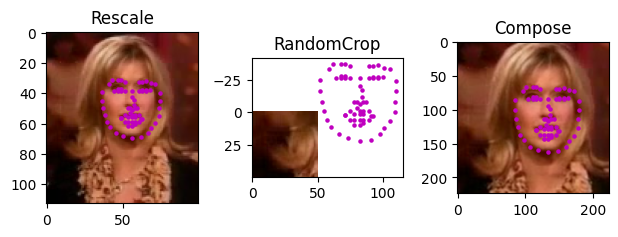

In [9]:
rescale = Rescale(100)
crop = RandomCrop(50)
composed = transforms.Compose([Rescale(250), RandomCrop(224)])
test_num = 500
sample = face_dataset[test_num]

fig = plt.figure()

for i, tx in enumerate([rescale, crop, composed]):
    transformed_sample = tx(sample)
    print(transformed_sample['image'].shape)
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tx).__name__)
    show_keypoints(transformed_sample['image'], transformed_sample['keypoints'])


## Create the transformed dataset

Here we apply the transforms in order to get grayscale images of the same shape. We also verify that our transform works by printing out the shape of the resulting data.

In [10]:
# define the data tranform
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),RandomCrop(224),Normalize(), ToTensor()])
                                     
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file_address='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)

In [11]:
# print some stats about the transformed data
print('Number of images: ', len(transformed_dataset))

# make sure the sample tensors are the expected size
for i in range(5):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])
4 torch.Size([1, 224, 224]) torch.Size([68, 2])
